In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import py_analyze_tools.tools as pat
import numpy as np
from pprint import pprint
import math

In [2]:
traj = pat.Trajectory("../generate/simple_trajectory_.h5")
traj.counts = traj.counts[:45*500]
traj.add_fusion(0, 1, 2)
traj.add_fission(2, 0, 1)
traj.add_conversion(0, 1)
traj.add_conversion(0, 3)
traj.add_conversion(3, 0)
xi = traj.estimate(.003)

max counts = 6000.0, min nonzero counts = 1.0


In [20]:
def magnitude(x):
    return math.floor(math.log10(x))

In [21]:
cv = pat.CV(traj)
result = cv.calculate_cost([0], range(0, 6000), range(6000, traj.n_time_steps))
norm_of_coeff = np.linalg.norm(result.coefficients[0], ord=1)
print("norm of coefficients for alpha=0: {}".format(norm_of_coeff))
quotient = result.costs_test[0]/norm_of_coeff
print("quotient = {}, order of magnitude = {}".format(quotient, magnitude(quotient)))

norm of coefficients for alpha=0: 0.012067573144616576
quotient = 0.220080932430265, order of magnitude = -1


In [29]:
search_grid = np.linspace(0, 10**(magnitude(quotient)+1), num=500)

In [30]:
cv_result = cv.calculate_cost(search_grid, range(0, 6000), range(6000, traj.n_time_steps))
min_idx = np.argmin(cv_result.costs_test)
print("best suited alpha found at idx={}, alpha={}, costs_test={}".format(min_idx, cv_result.alphas[min_idx], cv_result.costs_test[min_idx]))

best suited alpha found at idx=2, alpha=0.004008016032064128, costs_test=0.002593285670139532


# more complicated problem

In [31]:
traj = pat.Trajectory("../generate/simple_trajectory_2.h5")
traj.counts = traj.counts[:60*500]
traj.add_fusion(0, 1, 2)  # A + B -> C
traj.add_fusion(0, 2, 3)  # A + C -> D
traj.add_fusion(0, 3, 2)  # A + D -> C
traj.add_fusion(1, 2, 3)  # B + C -> D
traj.add_fission(2, 0, 1) # C -> A + B
traj.add_fission(0, 1, 2) # A -> B + C
traj.add_conversion(0, 1) # A -> B
traj.add_conversion(0, 3) # A -> D
traj.add_conversion(3, 0) # D -> A
traj.add_conversion(0, 2) # A -> C
traj.add_conversion(1, 2) # B -> C
traj.add_conversion(2, 3) # C -> D

max counts = 6000.0, min nonzero counts = 1.0
estimated coefficients: [  1.98092697e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.65213817e-05   6.90248650e-10   0.00000000e+00   9.62913871e-03
   9.88922299e-03   9.00130222e-10   0.00000000e+00   1.21190585e-09]
erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): 1.980926974951563e-06
lasso fitted rate (per volume): 0.006685628540461525


(0.068483983715421526, 1.9809269749515629e-06, 0.0066856285404615252)

In [47]:
def find_alpha(cv, n_grid_points=200, train_indices=range(0, 6000), test_indices=range(6000, 12000)):
    result = cv.calculate_cost([0], train_indices, test_indices)
    norm_of_coeff = np.linalg.norm(result.coefficients[0], ord=1)
    print("norm of coefficients for alpha=0: {}".format(norm_of_coeff))
    quotient = result.costs_test[0]/norm_of_coeff
    print("quotient = {}, order of magnitude = {}".format(quotient, magnitude(quotient)))
    
    search_grid = np.linspace(0, 10**(magnitude(quotient)+1), num=n_grid_points)
    cv_result = cv.calculate_cost(search_grid, train_indices, test_indices)
    min_idx = np.argmin(cv_result.costs_test)
    print("best suited alpha found at idx={}, alpha={}, costs_test={}".format(min_idx, cv_result.alphas[min_idx], cv_result.costs_test[min_idx]))
    return cv_result.alphas[min_idx]

In [48]:
cv = pat.CV(traj)
alpha = find_alpha(cv, n_grid_points=50)
print("found alpha=%s" % alpha)

norm of coefficients for alpha=0: 0.024661816504680387
quotient = 0.0926657685427791, order of magnitude = -2
best suited alpha found at idx=0, alpha=0.0, costs_test=0.002285306180067202
alpha[0]=0.0
found alpha=0.0


In [49]:
xi = traj.estimate(alpha)

estimated xi=[  1.98092697e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.65213817e-05   6.90248650e-10   0.00000000e+00   9.62913871e-03
   9.88922299e-03   9.00130222e-10   0.00000000e+00   1.21190585e-09]


In [51]:
print("estimated coefficients: %s" % xi)
_=traj.rate_info(xi[0])

estimated coefficients: [  1.98092697e-06   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.65213817e-05   6.90248650e-10   0.00000000e+00   9.62913871e-03
   9.88922299e-03   9.00130222e-10   0.00000000e+00   1.21190585e-09]
erban chapman rate (per volume): 0.06848398371542153
lasso fitted rate (per counts): 1.980926974951563e-06
lasso fitted rate (per volume): 0.006685628540461525


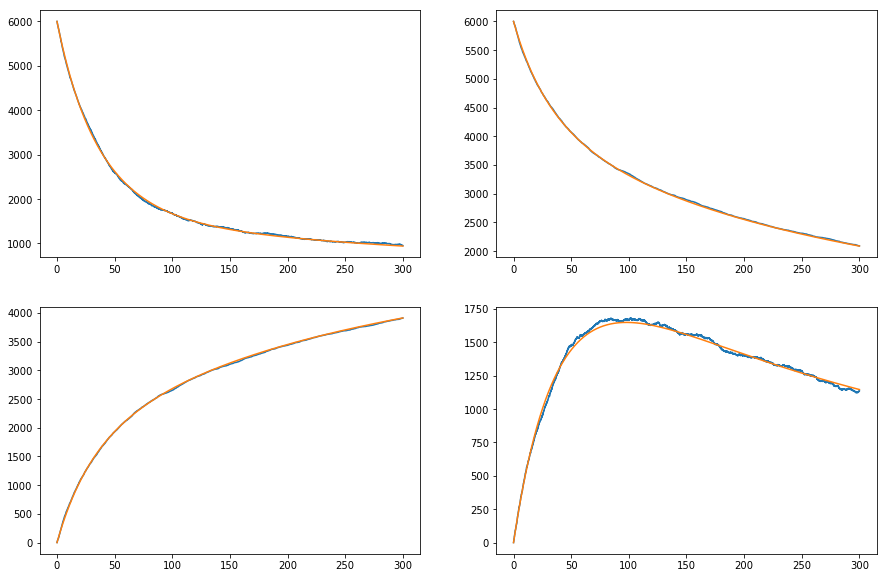

In [50]:
def fun(data, _):
    theta = np.array([f(data) for f in traj.thetas])
    return np.matmul(xi, theta)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
axes = [ax1, ax2, ax3, ax4]
for i in range(traj.n_species):
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i])
    axes[i].plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
plt.show()